# Update by the top view imaage

In [1]:
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
from cvla.utils_trajectory import project_point
import torch

def draw_multiple_poses_on_image(image, poses, camera, radius=5, axis_length=0.05):
    """
    Draws multiple 7D poses on an image and visualizes the local coordinate axes (x, y, z).

    Args:
        image (np.ndarray): The input RGB image of shape (H, W, 3).
        poses (List[torch.Tensor or np.ndarray]): A list of 7D poses (x, y, z, qx, qy, qz, qw).
        camera: A camera object with get_intrinsic_matrix() and get_extrinsic_matrix() methods.
        radius (int): Radius of the circle drawn at the pose origin.
        axis_length (float): Length of each axis arrow in 3D space (in meters).

    Returns:
        np.ndarray: The image with visualized poses and coordinate axes.
    """
    img = image.copy()

    positions = []
    x_dirs = []
    y_dirs = []
    z_dirs = []

    for pose in poses:
        if isinstance(pose, np.ndarray):
            pose = torch.tensor(pose)
        position = pose[:3]
        quat = pose[3:]

        # Convert quaternion to rotation matrix
        rot = R.from_quat(quat.cpu().numpy())
        rot_matrix = torch.tensor(rot.as_matrix(), dtype=torch.float32)  # shape: (3, 3)

        # Extract x, y, z axis directions from the rotation matrix
        x_axis = rot_matrix[:, 0]  # x-direction
        y_axis = rot_matrix[:, 1]  # y-direction
        z_axis = rot_matrix[:, 2]  # z-direction

        positions.append(position)
        x_dirs.append(x_axis)
        y_dirs.append(y_axis)
        z_dirs.append(z_axis)

    positions = torch.stack(positions)   # (N, 3)
    x_dirs = torch.stack(x_dirs)         # (N, 3)
    y_dirs = torch.stack(y_dirs)
    z_dirs = torch.stack(z_dirs)

    # Compute the 3D endpoints of the axes
    x_ends = positions + axis_length * x_dirs
    y_ends = positions + axis_length * y_dirs
    z_ends = positions + axis_length * z_dirs

    # Project the origins and endpoints to 2D image coordinates
    pts_start = project_point(camera, positions)  # (N, 2)
    x_2d = project_point(camera, x_ends)
    y_2d = project_point(camera, y_ends)
    z_2d = project_point(camera, z_ends)

    for i in range(len(poses)):
        x0, y0 = int(pts_start[i, 0]), int(pts_start[i, 1])
        cv2.circle(img, (x0, y0), radius, (255, 255, 255), -1)  # Draw the origin as a white dot

        # Helper function to draw arrows
        def draw_arrow(x1, y1, x2, y2, color):
            cv2.arrowedLine(img, (x1, y1), (x2, y2), color, 2, tipLength=0.2)

        # Draw the coordinate axes
        draw_arrow(x0, y0, int(x_2d[i, 0]), int(x_2d[i, 1]), (0, 0, 255))   # X-axis: red
        draw_arrow(x0, y0, int(y_2d[i, 0]), int(y_2d[i, 1]), (0, 255, 0))   # Y-axis: green
        draw_arrow(x0, y0, int(z_2d[i, 0]), int(z_2d[i, 1]), (255, 0, 0))   # Z-axis: blue

        # Label the origin point
        cv2.putText(img, f'P{i}', (x0 + 5, y0 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return img

In [2]:

"""
Main entry point for running the CVLA environment. See readme for details.
"""
import os
import json
import time
import random
import traceback
import multiprocessing
from pathlib import Path
from copy import deepcopy
from dataclasses import dataclass
from typing import List, Optional, Annotated, Union

import tyro
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import gymnasium as gym
import sapien

from mani_skill.utils.structs import Pose
from mani_skill.utils.wrappers import RecordEpisode
import mani_skill.examples.cvla.cvla_env  # do import to register env, not used otherwise
from mani_skill.examples.cvla.utils_trajectory import generate_curve_torch, DummyCamera
from mani_skill.examples.cvla.utils_traj_tokens import getActionEncInstance, to_prefix_suffix
from mani_skill.examples.cvla.utils_record import apply_check_object_pixels_obs
from mani_skill.examples.cvla.utils_record import downcast_seg_array

import gc
import torch

#for temperoray visualization
hand_cam_view = []
virtual_cam_view = []
depth_cam_view = []
cam_pose = Pose.create_from_pq(p=[0,0,0],q=[1,0,0,0])


RAND_MAX = 2**32 - 1
SAVE_FREQ = 1  # save after every reset
RESET_HARD = 10  # re-start environment after every n steps
SAVE_VIDEO = False  # save videos
# minimum percentage of image that must be object, set to None to disable checking
MIN_OBJ_VISIBLE_PERCENT = 0.5


def getMotionPlanner(env):
    if env.unwrapped.robot_uids in ("panda", "panda_wristcam"):
        from mani_skill.examples.motionplanning.panda.motionplanner import \
            PandaArmMotionPlanningSolver as RobotArmMotionPlanningSolver
    elif env.unwrapped.robot_uids == "fetch":
        from mani_skill.examples.motionplanning.fetch.motionplanner import \
            FetchArmMotionPlanningSolver as RobotArmMotionPlanningSolver
    else:
        raise ValueError(f"no motion planner for {env.unwrapped.robot_uids}")
    return RobotArmMotionPlanningSolver


@dataclass
class Args:
    env_id: Annotated[str, tyro.conf.arg(aliases=["-e"])] = "CvlaMove-v1"
    """The environment ID of the task you want to simulate"""

    obs_mode: Annotated[str, tyro.conf.arg(aliases=["-o"])] = "rgb+depth+segmentation"
    """Observation mode"""

    sim_backend: Annotated[str, tyro.conf.arg(aliases=["-b"])] = "auto"
    """Which simulation backend to use. Can be 'auto', 'cpu', 'gpu'"""

    reward_mode: Optional[str] = None
    """Reward mode"""

    num_envs: int = 1
    """Number of environments to run."""

    control_mode: Annotated[Optional[str], tyro.conf.arg(aliases=["-c"])] = "pd_joint_pos"
    """Control mode"""

    render_mode: str = "rgb_array"
    """Render mode"""

    shader: str = "default"
    """Change shader used for all cameras in the environment for rendering. Default is 'minimal' which is very fast. Can also be 'rt' for ray tracing and generating photo-realistic renders. Can also be 'rt-fast' for a faster but lower quality ray-traced renderer"""

    record_dir: Optional[str] = None
    """Directory to save recordings"""

    pause: Annotated[bool, tyro.conf.arg(aliases=["-p"])] = False
    """If using human render mode, auto pauses the simulation upon loading"""

    quiet: bool = False
    """Disable verbose output."""

    seed: Annotated[Optional[Union[int, List[int], str]], tyro.conf.arg(aliases=["-s"])] = None
    """Seed(s) for random actions and simulator. Can be a single integer or a list of integers. Default is None (no seeds)"""

    run_mode: Annotated[Optional[str], tyro.conf.arg(aliases=["-m"])] = "script"
    """Run mode, options are script, interactive, first"""

    robot_uids: Annotated[Optional[str], tyro.conf.arg(aliases=["-r"])] = "panda"
    """Robots, options are: panda, panda_wristcam, xarm6_robotiq, floating_inspire_hand_right"""

    scene_dataset: Annotated[Optional[str], tyro.conf.arg(aliases=["-sd"])] = "Table"
    """Scene datasets: options are: Table, ProcTHOR"""

    scene_options: Annotated[Optional[str], tyro.conf.arg(aliases=["-so"])] = "fixed"
    """Randomize the scene"""

    object_dataset: Annotated[Optional[str], tyro.conf.arg(aliases=["-od"])] = "clevr"
    """Dataset from which we sample objects, options are: clevr, ycb, objaverse"""

    camera_views: Annotated[Optional[str], tyro.conf.arg(aliases=["-cv"])] = "random_side"
    """Dataset from which we sample objects"""

    action_encoder: Annotated[Optional[str], tyro.conf.arg(aliases=["-ae"])] = "xyzrotvec-cam-1024xy"
    """Action encoding"""

    N_samples: Annotated[Optional[int], tyro.conf.arg(aliases=["-N"])] = 50
    """Number of samples"""


def reset_random(args, orig_seeds=None):
    if orig_seeds is None:
        seed = random.randrange(RAND_MAX)
    elif isinstance(orig_seeds, list):
        seed = orig_seeds.pop()
    elif isinstance(orig_seeds, int):
        seed = orig_seeds
    else:
        raise ValueError
    args.seed = [seed]
    np.random.seed(seed)


def iterate_env(args: Args, vis=True, model=None):
    np.set_printoptions(suppress=True, precision=3)
    verbose = not args.quiet
    parallel_in_single_scene = args.render_mode == "human"
    if args.render_mode == "human" and args.obs_mode in ["sensor_data", "rgb", "rgbd", "depth", "point_cloud", "top_view"]:
        print("Disabling parallel single scene/GUI render as observation mode is a visual one. Change observation mode to state or state_dict to see a parallel env render")
        parallel_in_single_scene = False
    if args.render_mode == "human" and args.num_envs == 1:
        parallel_in_single_scene = False

    # define make env as a function to enable hard resets
    def make_env():
        env = gym.make(
            args.env_id,
            obs_mode=args.obs_mode,
            reward_mode=args.reward_mode,
            control_mode=args.control_mode,
            render_mode=args.render_mode,
            sensor_configs=dict(shader_pack=args.shader),
            human_render_camera_configs=dict(shader_pack=args.shader),
            viewer_camera_configs=dict(shader_pack=args.shader),
            num_envs=args.num_envs,
            sim_backend=args.sim_backend,
            parallel_in_single_scene=parallel_in_single_scene,
            robot_uids=args.robot_uids,
            scene_dataset=args.scene_dataset,
            object_dataset=args.object_dataset,
            camera_views=args.camera_views,
            scene_options=args.scene_options,
            # camera_cfgs={"use_stereo_depth": True, },
            # **args.env_kwargs
        )
        if args.record_dir:
            env = RecordEpisode(env, args.record_dir, info_on_video=False,
                                save_trajectory=True, max_steps_per_video=env._max_episode_steps,
                                save_on_reset=SAVE_FREQ == 1,
                                record_env_state=True)
        return env

    env = make_env()
    print("render camera loc after the scene was rendered ")
    print(env.render_camera_config.pose)
    if verbose:
        print("Observation space", env.observation_space)
        print("Action space", env.action_space)
        print("Control mode", env.unwrapped.control_mode)
        print("Reward mode", env.unwrapped.reward_mode)
        print("Render mode", args.render_mode)
        print("Obs mode", args.obs_mode)

    filter_visible = True
    action_encoder = getActionEncInstance(args.action_encoder)
    enc_func, dec_func = action_encoder.encode_trajectory, action_encoder.decode_trajectory

    orig_seeds = args.seed
    N_valid_samples = 0
    max_attempts = 10**6
    for i in range(max_attempts):
        #here if set parameters as (agrs, orig_seeds) can same scenes
        reset_random(args)
        assert isinstance(args.seed, list)

        if i != 0 and i % RESET_HARD == 0:
            del env
            env = make_env()
            print("render camera loc in a new scene ")
            
            print(env.render_camera_config.pose)
        try:
            obs, _ = env.reset(seed=args.seed[0], options=dict(reconfigure=True))
        except Exception as e:  # Catch all exceptions, including AssertionError
            print(f"Encountered error {e.__class__.__name__} at seed {args.seed[0]} while resetting env. Skipping this iteration.")
            print(e)
            traceback.print_exc()  # Prints the full traceback
            gc.collect()
            torch.cuda.empty_cache()
            continue

        if MIN_OBJ_VISIBLE_PERCENT is None:
            obj_are_vis = True
        elif "top" in str(args.camera_views): # from the top-view above the fisrt object, can't see two objects
            obj_are_vis = True
        else:
            obj_are_vis = apply_check_object_pixels_obs(obs, env, N_percent=MIN_OBJ_VISIBLE_PERCENT)
        if not obj_are_vis:
            print("Warning: object not visible, skipping sample")
            gc.collect()
            torch.cuda.empty_cache()
            continue

        # Note: when using RecordEpisode this will create 20x the number of saved frames
        # so 75GB -> 1.5 TB, which is no good.
        # Let the objects settle (!)
        # for _ in range(20):
        #    _ = env.step(obs["agent"]["qpos"][..., :8])
        
        #debug only, to check where is the camera
        print("render camera loc at the end")
        cam_pose = env.render_camera_config.pose
        print(env.render_camera_config.pose)
        
        if args.seed is not None:
            env.action_space.seed(args.seed[0])
        if vis and args.render_mode is not None:
            viewer = env.render()
            if isinstance(viewer, sapien.utils.Viewer):
                viewer.paused = args.pause
            env.render()
        else:
            env.render()

        # Not parrelized
        # env_idx = 0

        # -----
        # Warning, taking an image form obs/rendering it results in different calibrations!
        # e.g. images = env.base_env.scene.get_human_render_camera_images('render_camera')
        # -----
        obj_start = Pose(obs["extra"]["obj_start"].clone().detach())
        obj_end = Pose(obs["extra"]["obj_end"].clone().detach())
        grasp_pose = Pose(obs["extra"]["grasp_pose"].clone().detach())
        tcp_pose = Pose(obs["extra"]["tcp_pose"].clone().detach())
        robot_pose = Pose(obs["extra"]["robot_pose"].clone().detach())

        try:
            camera_intrinsic = obs["sensor_param"]["render_camera"]["intrinsic_cv"].clone().detach()
            #camera_intrinsic[0,:-1,2] = 0
            camera_extrinsic = obs["sensor_param"]["render_camera"]["extrinsic_cv"].clone().detach()
            image_before = obs["sensor_data"]["render_camera"]["rgb"][0].clone().detach()
            depth = obs["sensor_data"]["render_camera"]["depth"][0].clone().detach()
            width, height, _ = image_before.shape
            camera = DummyCamera(camera_intrinsic, camera_extrinsic, width, height)
            # add depth to image_before if this mode take depth
            if "depth" in str(args.obs_mode) and "top" not in str(args.camera_views):
                image_before = (depth, image_before)
        except KeyError:
            image_before = obs["sensor_data"]["render_camera"]["rgb"][0].clone().detach()
            camera = env.base_env.scene.human_render_cameras['render_camera'].camera

        action_text = env.unwrapped.get_obs_scene()["text"]
        assert isinstance(action_text, str) and action_text not in (None, ""), f"action_text: {action_text}"

        print("intrinsic")
        print(camera_intrinsic)
        prefix, token_str, curve_3d, orns_3d, info = to_prefix_suffix(obj_start, obj_end,
                                                                      camera, grasp_pose, tcp_pose,
                                                                      action_text, enc_func, robot_pose=robot_pose)
        #debug only
        print("first curve")
        print(curve_3d[:,0])
        print(grasp_pose.get_p())
        

        '''
        extra:
        obj_start
        obj_end
        grasp_pose
        tcp_pose
        robot_pose
            
        '''
        

        #top_view.append(image_before)
        json_dict = dict(prefix=prefix, suffix=token_str,
                         action_text=action_text,
                         camera_extrinsic=camera.get_extrinsic_matrix().detach().numpy().tolist(),
                         camera_intrinsic=camera.get_intrinsic_matrix().detach().numpy().tolist(),
                         obj_start_pose=obj_start.raw_pose.detach().numpy().tolist(),
                         obj_end_pose=obj_end.raw_pose.detach().numpy().tolist(),
                         robot_pose=robot_pose.raw_pose.detach().numpy().tolist(),
                         tcp_start_pose=tcp_pose.raw_pose.detach().numpy().tolist(),
                         grasp_pose=grasp_pose.raw_pose.detach().numpy().tolist(),
                         info=info,
                         seed=args.seed[0],
                         iter_reached=i,
                         )

        encode_decode_trajectory = True
        if encode_decode_trajectory:
            curve_3d_est, orns_3d_est = dec_func(token_str, camera, robot_pose=robot_pose)
            curve_3d = curve_3d_est  # set the unparsed trajectory one used for policy
            orns_3d = orns_3d_est
        def get_pose_of_new_predicts(image,prefix,model):
            pose_list = []
            return pose_list

        # Evaluate the trajectory
        if args.run_mode == "script" or model:
            assert args.control_mode == "pd_joint_pos"
            if verbose and info["didclip_traj"]:
                print("Warning refered object out of camera view.")
                

            if model:
                '''
                print(f"prefix:{prefix}")
                print(f"image type:{type(image_before)}")
                print("visualize of image before")
                show_before = image_before.cpu().numpy()
                plt.imshow(show_before)
                plt.axis('off')  # Turn off axis numbers/labels
                plt.show()
                '''
                _, _, _, token_pred = model.make_predictions(image_before, prefix)
                json_dict["prediction"] = token_pred
                if token_pred == "" or token_pred is None:
                    print("Warning: empty prediction, failing")
                    json_dict["reward"] = 0
                    gc.collect()
                    torch.cuda.empty_cache()
                    yield image_before, json_dict, args.seed[0]
                    continue

                try:
                    curve_3d_pred, orns_3d_pred = dec_func(token_pred, camera=camera, robot_pose=robot_pose)
                    curve_3d = curve_3d_pred  # set the unparsed trajectory one used for policy
                    orns_3d = orns_3d_pred
                # TODO(max): this should only catch value errors
                except:
                    print("Warning: exception during decoding tokens, failing", token_pred)
                    json_dict["reward"] = 0
                    gc.collect()
                    torch.cuda.empty_cache()
                    yield image_before, json_dict, args.seed[0]
                    continue

            # start and stop poses
            if curve_3d.shape[1] != 2 or orns_3d.shape[1] != 2:
                print("Warning: Model decoded something that is not a valid trajectory")
                json_dict["reward"] = 0.0
                gc.collect()
                torch.cuda.empty_cache()
                yield image_before, json_dict, args.seed[0]
                N_valid_samples += 1
                continue
            
            # convert two keypoints into motion sequence
            _, curve_3d_i = generate_curve_torch(curve_3d[:, 0], curve_3d[:, -1], num_points=3)
            grasp_pose = Pose.create_from_pq(p=curve_3d[:, 0], q=orns_3d[:, 0])
            reach_pose = grasp_pose * sapien.Pose([0, 0, -0.10])  # Go above the object before grasping
            lift_pose = Pose.create_from_pq(p=curve_3d_i[:, 1], q=orns_3d[:, 1])
            align_pose = Pose.create_from_pq(p=curve_3d_i[:, 2], q=orns_3d[:, 1])
            pre_align_pose = align_pose * sapien.Pose([0, 0, -0.10])  # Go above before dropping
            print("check the difference")
            print(grasp_pose.p)
            print(reach_pose.p)



            #check the actual location of robot
            obs2 = env.base_env.get_obs()
            #draw these two points on the imgage
            image1 = obs2["sensor_data"]["render_camera"]["rgb"][0].clone().detach()
            image1 = image1.cpu().numpy()
            #pose_raw2 = env.render_camera_config.pose
            #pose_raw2 = pose_raw2.raw_pose.squeeze(0)  # make it a tensor
            #point_3d = [obs2["extra"]["tcp_pose"][0], pose_raw2]
            obj_start = obs2["extra"]["obj_start"][0]
            obj_end = obs2["extra"]["obj_end"][0]
            zero_t = torch.zeros_like(obj_start)
            zero_t[3:] = obj_start[3:]
            print("the pose of obj_start")
            print(obj_start)
            print("the pose of obj_end")
            print(obj_end)
            print("camera pose")
            print(cam_pose)
            cam_pose_p = cam_pose.p
            cam_pose_q = cam_pose.q
            low_cam = torch.tensor([cam_pose_p[0][0], cam_pose_p[0][1], 0, cam_pose_q[0][0], 
                                     cam_pose_q[0][1], cam_pose_q[0][2], cam_pose_q[0][3]], dtype=torch.float32)
            
            point_3d = [obj_start, obj_end,low_cam ]
            output_img = draw_multiple_poses_on_image(image1, point_3d, camera)
            

            
            plt.imshow(output_img)
            plt.axis('off')
            plt.show()
            

            # execute motion sequence using IK solver
            RobotArmMotionPlanningSolver = getMotionPlanner(env)
            planner = RobotArmMotionPlanningSolver(
                env,
                debug=False,
                vis=vis,
                base_pose=env.unwrapped.agent.robot.pose,
                visualize_target_grasp_pose=vis,
                print_env_info=False,
            )
            planner.move_to_pose_with_screw(reach_pose)
           
            
            #get the current observation from top
            
            obs1 = env.base_env.get_obs() 
            image1 = obs1["sensor_data"]["render_camera"]["rgb"][0].clone().detach()
            virtual_cam_view.append(image1)
            image2 = obs1["sensor_data"]["hand_camera"]["rgb"][0].clone().detach()
            hand_cam_view.append(image2)
            image3 = obs1["sensor_data"]["render_camera"]["depth"][0].clone().detach()
            depth_cam_view.append(image3)
            
            #for key in obs1["sensor_data"]["render_camera"].keys():
            #   print(key)

            #image_top = image_top.cpu().numpy()
            #plt.imshow(image_top)
            #plt.axis('off')  # Turn off axis numbers/labels
            #plt.show()
            '''
            if model:
                _, _, _, token_pred = model.make_predictions(image_top, prefix)
                json_dict["prediction"] = token_pred
                if token_pred == "" or token_pred is None:
                    print("Warning: empty prediction, failing")
                    json_dict["reward"] = 0
                    gc.collect()
                    torch.cuda.empty_cache()
                    yield image_before, json_dict, args.seed[0]
                    continue

                try:
                    curve_3d_pred, orns_3d_pred = dec_func(token_pred, camera=camera, robot_pose=robot_pose)
                    curve_3d = curve_3d_pred  # set the unparsed trajectory one used for policy
                    orns_3d = orns_3d_pred
                # TODO(max): this should only catch value errors
                except:
                    print("Warning: exception during decoding tokens, failing", token_pred)
                    json_dict["reward"] = 0
                    gc.collect()
                    torch.cuda.empty_cache()
                    yield image_before, json_dict, args.seed[0]
                    continue
            # start and stop poses
            if curve_3d.shape[1] != 2 or orns_3d.shape[1] != 2:
                print("Warning: Model decoded something that is not a valid trajectory")
                json_dict["reward"] = 0.0
                gc.collect()
                torch.cuda.empty_cache()
                yield image_before, json_dict, args.seed[0]
                N_valid_samples += 1
                continue

            # convert two keypoints into motion sequence
            _, curve_3d_i = generate_curve_torch(curve_3d[:, 0], curve_3d[:, -1], num_points=3)
            print(f"origin grasp pos:{grasp_pose}")
            grasp_pose_rotation = Pose.create_from_pq(p=curve_3d[:, 0], q=orns_3d[:, 0])
            grasp_pose.raw_pose[0, 3:] = grasp_pose_rotation.raw_pose[0, 3:]
            print(f"Updated grasp pos:{grasp_pose}")
           '''
            '''
            #check the actual location of robot
            obs2 = env.base_env.get_obs()
            #draw these two points on the imgage
            image1 = image1.cpu().numpy()
            pose_raw2 = env.render_camera_config.pose
            pose_raw2 = pose_raw2.raw_pose.squeeze(0)  # make it a tensor

            #point_3d = [obs2["extra"]["tcp_pose"][0], pose_raw2]
            obj_start = obs2["extra"]["obj_start"][0]
            obj_end = obs2["extra"]["obj_end"][0]
            zero_t = torch.zeros_like(obj_start)
            zero_t[3:] = obj_start[3:]
            print("the pose of obj_start")
            print(obj_start)
            print("the pose of obj_end")
            print(obj_end)
            print("camera pose")
            cam_pose_p = cam_pose.p
            cam_pose_q = cam_pose.q
            temp_cam = torch.tensor([cam_pose_p[0][0], cam_pose_p[0][1], 0.3, cam_pose_q[0][0], 
                                     cam_pose_q[0][1], cam_pose_q[0][2], cam_pose_q[0][3]], dtype=torch.float32)
            print(temp_cam)
            
            point_3d = [obj_start, obj_end,temp_cam ]
            output_img = draw_multiple_poses_on_image(image1, point_3d, camera)
            

            
            plt.imshow(output_img)
            plt.axis('off')
            plt.show()
            '''

            
            planner.move_to_pose_with_screw(grasp_pose)
            # run_interactive(env)
            planner.close_gripper()
            planner.move_to_pose_with_screw(lift_pose)
            planner.move_to_pose_with_screw(pre_align_pose)
            planner.move_to_pose_with_screw(align_pose)
            # run_interactive(env)
            planner.open_gripper()
            final_reward = env.unwrapped.eval_reward()[0]
            planner.close()
    
            json_dict["reward"] = float(final_reward)
            if verbose:
                print(f"reward {final_reward:0.2f} seed", args.seed[0])

        elif args.run_mode == "interactive":
            run_interactive(env)
        elif args.run_mode == "first":
            # only render first frame
            pass
        else:
            raise ValueError

        # adding the top view image to 
        if "top" in str(args.camera_views):
            image_before = image_before
            #obs["sensor_data"]["render_camera"]["depth"][0] = obs1["sensor_data"]["hand_camera"]["rgb"][0].clone().detach()

        if args.record_dir:
            # if i % SAVE_FREQ == 0:
            # keep the transition from reset (which does not have an action)

            downcast_seg_array(env)
            env.flush_trajectory(save=True, ignore_empty_transition=False)
            # to skip saving do: env.flush_trajectory(save=False)

            if SAVE_VIDEO:
                video_name = f"CLEVR_{str(args.seed[0]).zfill(10)}"
                env.flush_video(name=video_name, save=True)

        del obs
        gc.collect()
        torch.cuda.empty_cache()

       
            
        yield image_before, json_dict, args.seed[0]

        N_valid_samples += 1

    env.close()


def run_interactive(env):
    env.print_sim_details()
    print("Entering do nothing loop: Ctrl-C to continue")
    try:
        while True:
            time.sleep(.1)
            env.base_env.render_human()
    except KeyboardInterrupt:
        print("\nCtrl+C detected, continuing.")


def run_iteration(parsed_args, N_samples, process_num=None, progress_bar=None):
    """Runs the environment iteration in a separate process."""
    env_iter = iterate_env(parsed_args, vis=False)
    for _ in range(N_samples):
        _ = next(env_iter)
        if progress_bar is not None:
            progress_bar.value += 1


def save_multiproces(parsed_args, N_samples, N_processes=10):
    from mani_skill.examples.cvla.utils_record import check_no_uncommitted_changes, get_git_commit_hash
    parsed_args.run_mode = "first"
    dataset_path = Path(parsed_args.record_dir)
    os.makedirs(dataset_path, exist_ok=True)

    # save command line arguments in nice format
    if N_samples > 100:
        check_no_uncommitted_changes()
    commit_hash = get_git_commit_hash()
    with open(dataset_path / "args.txt", "w") as f:
        f.write(f"git_commit: {commit_hash}\n")
        for arg in vars(parsed_args):
            f.write(f"{arg}: {getattr(parsed_args, arg)}\n")

    # set random seeds, be careful to not copy same seeds between processes
    if N_processes > 1:
        assert parsed_args.seed is None
    if isinstance(parsed_args.seed, int):
        assert N_processes == 1
        rng = np.random.default_rng(parsed_args.seed)
        parsed_args.seed = rng.integers(0, RAND_MAX, N_samples).tolist()

    # don't multiprocess
    if N_processes == 1:
        # don't set N_samples in iterate_env, so that e.g. re-generate can work for visibility
        env_iter = iterate_env(parsed_args, vis=False)
        for _ in tqdm(range(N_samples)):
            try:
                _ = next(env_iter)
            except StopIteration:
                break
    else:
        samples_per_process = N_samples // N_processes
        progress_bar = multiprocessing.Value("i", 0)

        tasks = []
        for p_num in range(N_processes):
            dataset_path_p = Path(dataset_path) / f"p{p_num}"
            os.makedirs(dataset_path_p, exist_ok=True)
            args_copy = deepcopy(parsed_args)
            args_copy.record_dir = dataset_path_p
            p = multiprocessing.Process(target=run_iteration, args=(args_copy, samples_per_process, p_num, progress_bar), name=f"Worker-{p_num+1}")
            tasks.append(p)
            p.start()
            time.sleep(1.1)  # Give some time for processes to start

        # Display tqdm progress in the main process
        with tqdm(total=N_samples, desc="Total Progress", position=0, leave=True) as pbar:
            last_count = 0
            while any(p.is_alive() for p in tasks):  # Update while processes are running
                current_count = progress_bar.value
                pbar.update(current_count - last_count)  # Update tqdm only for new progress
                last_count = current_count
                time.sleep(1)  # Prevents excessive updates

        # await asyncio.gather(*tasks)
        for p in tasks:
            p.join()  # Wait for all processes to finish

/home/zhangj/miniconda3/envs/mani_skill/lib/python3.12/site-packages/sapien/_vulkan_tricks.py:21: UserWarning: Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.
  warn("Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.")


ChatGPT describer not loaded


### Generate the training data in simulation

In [3]:
import torch
torch.cuda.is_available()

True

[autoreload of mani_skill.examples.cvla.cvla_env failed: Traceback (most recent call last):
  File "/home/zhangj/miniconda3/envs/mani_skill/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/zhangj/miniconda3/envs/mani_skill/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1133, in get_code
  File "<frozen importlib._bootstrap_external>", line 1063, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/work/dlclarge2/zhangj-zhan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|                                                                                              | 0/15 [00:00<?, ?it/s]

list_a before given to camera
[0.5, 0.3, 0]
text description
move cupcake with candle onto cube
list_a
[-0.1515, 0.1139, 0]
tensor([[-0.1515,  0.1139,  0.0734]])
list_a before given to camera
[-0.1515, 0.1139, 0]
render camera loc after the scene was rendered 
Pose(raw_pose=tensor([[-0.1515,  0.1139,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


/home/zhangj/miniconda3/envs/mani_skill/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_camera_config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_camera_config` for environment variables or `env.get_wrapper_attr('render_camera_config')` that will search the reminding wrappers.
  logger.warn(


text description
move curved beak skull onto cylindrical white mug
list_a
[-0.1663, -0.234, 0]
tensor([[-0.1663, -0.2340,  0.0722]])
list_a before given to camera
[-0.1663, -0.234, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1663, -0.2340,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1663, -0.2340,  0.0722]])
tensor([[-0.1663, -0.2340,  0.0722]])
check the difference
tensor([[-0.1665, -0.0664,  0.0700]])
tensor([[-0.1695, -0.0668,  0.1700]])
the pose of obj_start
tensor([-0.1515, -0.2488,  0.0000,  0.6778, -0.0000, -0.0000, -0.7353])
the pose of obj_end
tensor([-0.2678, -0.1181,  0.0636,  0.6778, -0.0000, -0.0000, -0.7353])
camera pose
Pose(raw_pose=tensor([[-0.1663, -0.2340,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


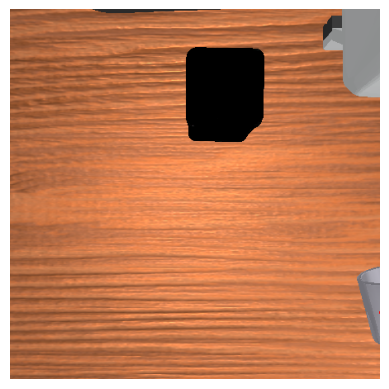

  7%|█████▋                                                                                | 1/15 [00:25<05:57, 25.53s/it]

text description
move purple game console onto spherical mesh microphone
list_a
[0.0067, -0.2026, 0]
tensor([[ 0.0067, -0.2026,  0.0928]])
list_a before given to camera
[0.0067, -0.2026, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[ 0.0067, -0.2026,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[ 0.0067, -0.2026,  0.0928]])
tensor([[ 0.0067, -0.2026,  0.0928]])
check the difference
tensor([[ 0.0024, -0.2024,  0.0900]])
tensor([[ 0.0005, -0.2009,  0.1900]])
the pose of obj_start
tensor([ 0.0054, -0.2030,  0.0000,  0.7857,  0.0000,  0.0000, -0.6186])
the pose of obj_end
tensor([-0.0477,  0.0011,  0.1161,  0.7857,  0.0000,  0.0000, -0.6186])
camera pose
Pose(raw_pose=tensor([[ 0.0067, -0.2026,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


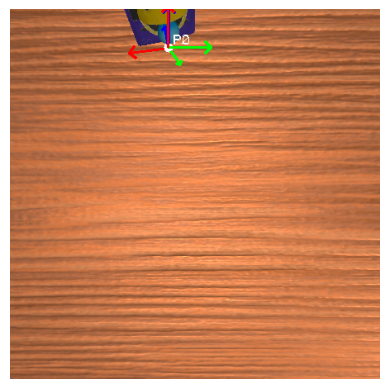

 13%|███████████▍                                                                          | 2/15 [00:41<04:17, 19.78s/it]

text description
move realistic bug model onto black revolver
list_a
[-0.1765, -0.1274, 0]
tensor([[-0.1765, -0.1274,  0.0112]])
list_a before given to camera
[-0.1765, -0.1274, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1765, -0.1274,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1765, -0.1274,  0.0112]])
tensor([[-0.1765, -0.1274,  0.0112]])
check the difference
tensor([[-0.1772, -0.1274,  0.0100]])
tensor([[-0.1800, -0.1267,  0.1100]])
the pose of obj_start
tensor([-0.1763, -0.1275,  0.0000,  0.5257, -0.0000, -0.0000, -0.8507])
the pose of obj_end
tensor([-0.1840,  0.1438,  0.0754,  0.5257, -0.0000, -0.0000, -0.8507])
camera pose
Pose(raw_pose=tensor([[-0.1765, -0.1274,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


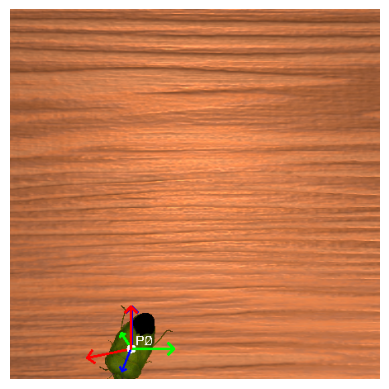

 20%|█████████████████▏                                                                    | 3/15 [01:04<04:14, 21.17s/it]

text description
move decorative soup bowl onto bright pink character
list_a
[-0.0664, 0.1104, 0]
tensor([[-0.0664,  0.1104,  0.0206]])
list_a before given to camera
[-0.0664, 0.1104, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.0664,  0.1104,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.0664,  0.1104,  0.0206]])
tensor([[-0.0664,  0.1104,  0.0206]])
check the difference
tensor([[-0.0663,  0.0794,  0.0200]])
tensor([[-0.0680,  0.0809,  0.1200]])
the pose of obj_start
tensor([-0.0664,  0.1104,  0.0000,  0.7280,  0.0000,  0.0000,  0.6855])
the pose of obj_end
tensor([-0.2881, -0.0018,  0.1254,  0.7280,  0.0000,  0.0000,  0.6855])
camera pose
Pose(raw_pose=tensor([[-0.0664,  0.1104,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


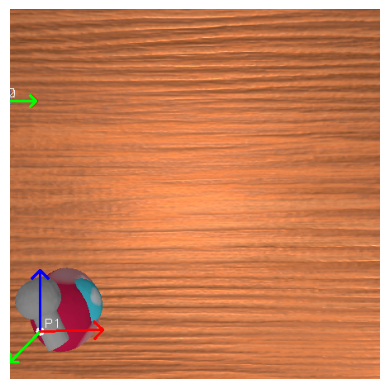

 27%|██████████████████████▉                                                               | 4/15 [01:24<03:49, 20.83s/it]

text description
move glossy beetle model onto sandwich holder
list_a
[-0.143, 0.0735, 0]
tensor([[-0.1430,  0.0735,  0.0177]])
list_a before given to camera
[-0.143, 0.0735, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1430,  0.0735,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1430,  0.0735,  0.0177]])
tensor([[-0.1430,  0.0735,  0.0177]])
check the difference
tensor([[-0.1425,  0.0737,  0.0200]])
tensor([[-0.1451,  0.0747,  0.1200]])
the pose of obj_start
tensor([-0.1435,  0.0725,  0.0000,  0.9071,  0.0000,  0.0000,  0.4208])
the pose of obj_end
tensor([-0.2423, -0.2462,  0.1199,  0.9071,  0.0000,  0.0000,  0.4208])
camera pose
Pose(raw_pose=tensor([[-0.1430,  0.0735,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


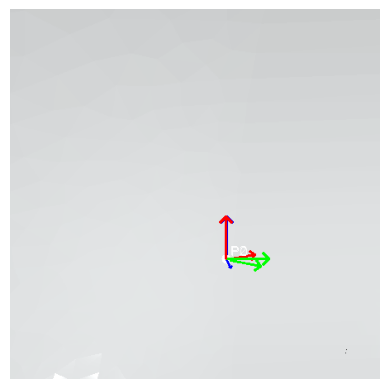

 33%|████████████████████████████▋                                                         | 5/15 [01:46<03:31, 21.14s/it]

text description
move red lenses onto pink can
list_a
[-0.1953, 0.0138, 0]
tensor([[-0.1953,  0.0138,  0.0247]])
list_a before given to camera
[-0.1953, 0.0138, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1953,  0.0138,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1953,  0.0138,  0.0247]])
tensor([[-0.1953,  0.0138,  0.0247]])
check the difference
tensor([[-0.1960,  0.0132,  0.0200]])
tensor([[-0.1991,  0.0131,  0.1200]])
the pose of obj_start
tensor([-0.1944,  0.0181,  0.0000,  0.9940,  0.0000,  0.0000,  0.1093])
the pose of obj_end
tensor([-0.2399,  0.2780,  0.0395,  0.9940,  0.0000,  0.0000,  0.1093])
camera pose
Pose(raw_pose=tensor([[-0.1953,  0.0138,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


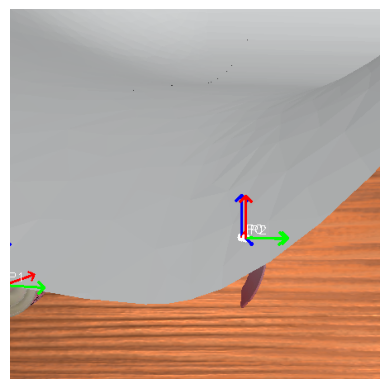

 40%|██████████████████████████████████▍                                                   | 6/15 [02:13<03:29, 23.25s/it]

text description
move toy ambulance onto seashell
list_a
[-0.0823, -0.1446, 0]
tensor([[-0.0823, -0.1446,  0.0505]])
list_a before given to camera
[-0.0823, -0.1446, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.0823, -0.1446,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.0823, -0.1446,  0.0505]])
tensor([[-0.0823, -0.1446,  0.0505]])
check the difference
tensor([[-0.0822, -0.1449,  0.0500]])
tensor([[-0.0845, -0.1436,  0.1500]])
the pose of obj_start
tensor([-0.0822, -0.1445,  0.0000,  0.9635,  0.0000,  0.0000,  0.2677])
the pose of obj_end
tensor([0.1501, 0.2296, 0.0842, 0.9635, 0.0000, 0.0000, 0.2677])
camera pose
Pose(raw_pose=tensor([[-0.0823, -0.1446,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


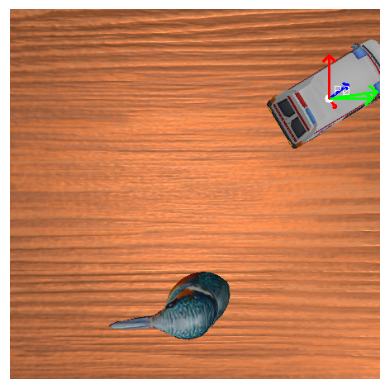

 47%|████████████████████████████████████████▏                                             | 7/15 [02:34<03:01, 22.65s/it]

text description
move rounded lavender teapot onto u-shaped red magnet
list_a
[-0.1104, -0.2122, 0]
tensor([[-0.1104, -0.2122,  0.0333]])
list_a before given to camera
[-0.1104, -0.2122, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1104, -0.2122,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1104, -0.2122,  0.0333]])
tensor([[-0.1104, -0.2122,  0.0333]])
check the difference
tensor([[-0.1106, -0.2128,  0.0300]])
tensor([[-0.1135, -0.2132,  0.1300]])
the pose of obj_start
tensor([-0.1089, -0.2140,  0.0000,  0.9747,  0.0000,  0.0000, -0.2234])
the pose of obj_end
tensor([-0.1336,  0.2154,  0.1000,  0.9747,  0.0000,  0.0000, -0.2234])
camera pose
Pose(raw_pose=tensor([[-0.1104, -0.2122,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


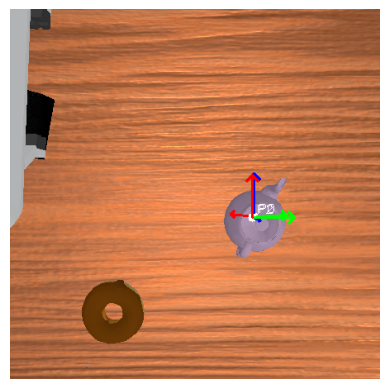

 53%|█████████████████████████████████████████████▊                                        | 8/15 [02:54<02:32, 21.75s/it]

text description
move colorful caps onto abstract egg sculpture
list_a
[-0.1772, -0.0749, 0]
tensor([[-0.1772, -0.0749,  0.0259]])
list_a before given to camera
[-0.1772, -0.0749, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1772, -0.0749,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1772, -0.0749,  0.0259]])
tensor([[-0.1772, -0.0749,  0.0259]])
check the difference
tensor([[-0.1766, -0.0765,  0.0300]])
tensor([[-0.1795, -0.0759,  0.1300]])
the pose of obj_start
tensor([-0.1767, -0.0735,  0.0000,  0.1843,  0.0000,  0.0000,  0.9829])
the pose of obj_end
tensor([-0.1298,  0.0827,  0.1050,  0.1843,  0.0000,  0.0000,  0.9829])
camera pose
Pose(raw_pose=tensor([[-0.1772, -0.0749,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


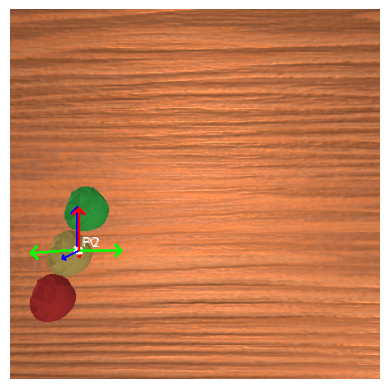

 60%|███████████████████████████████████████████████████▌                                  | 9/15 [03:16<02:10, 21.75s/it]

text description
move pink character onto emoji
list_a
[0.099, -0.218, 0]
tensor([[ 0.0990, -0.2180,  0.0560]])
list_a before given to camera
[0.099, -0.218, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[ 0.0990, -0.2180,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[ 0.0990, -0.2180,  0.0560]])
tensor([[ 0.0990, -0.2180,  0.0560]])
check the difference
tensor([[ 0.0078, -0.2163,  0.0600]])
tensor([[ 0.0061, -0.2148,  0.1600]])
the pose of obj_start
tensor([ 0.0975, -0.2143,  0.0000,  0.7442,  0.0000,  0.0000,  0.6680])
the pose of obj_end
tensor([0.1342, 0.2287, 0.0689, 0.7442, 0.0000, 0.0000, 0.6680])
camera pose
Pose(raw_pose=tensor([[ 0.0990, -0.2180,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


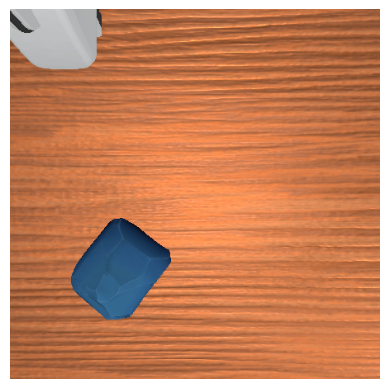

 67%|████████████████████████████████████████████████████████▋                            | 10/15 [03:32<01:39, 19.89s/it]

list_a before given to camera
[0.5, 0.3, 0]
text description
move cupcake with candle onto cube
list_a
[-0.1515, 0.1139, 0]
tensor([[-0.1515,  0.1139,  0.0734]])
list_a before given to camera
[-0.1515, 0.1139, 0]
render camera loc in a new scene 
Pose(raw_pose=tensor([[-0.1515,  0.1139,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


/home/zhangj/miniconda3/envs/mani_skill/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_camera_config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_camera_config` for environment variables or `env.get_wrapper_attr('render_camera_config')` that will search the reminding wrappers.
  logger.warn(


text description
move round shield onto flexible rectangular covering
list_a
[-0.2251, 0.0296, 0]
tensor([[-0.2251,  0.0296,  0.0259]])
list_a before given to camera
[-0.2251, 0.0296, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.2251,  0.0296,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.2251,  0.0296,  0.0259]])
tensor([[-0.2251,  0.0296,  0.0259]])
check the difference
tensor([[-0.2244,  0.0303,  0.0300]])
tensor([[-0.2275,  0.0302,  0.1300]])
the pose of obj_start
tensor([-0.2251,  0.0306,  0.0000,  0.9988,  0.0000,  0.0000,  0.0484])
the pose of obj_end
tensor([-0.1532,  0.0104,  0.0099,  0.9988,  0.0000,  0.0000,  0.0484])
camera pose
Pose(raw_pose=tensor([[-0.2251,  0.0296,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


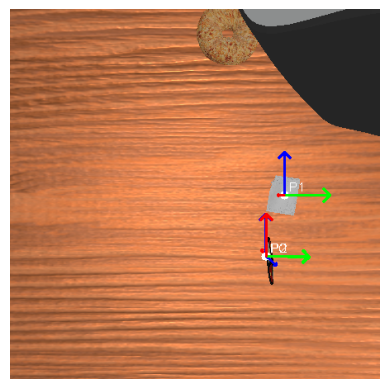

 73%|██████████████████████████████████████████████████████████████▎                      | 11/15 [03:58<01:27, 21.85s/it]

text description
move rough turquoise slab onto fiery skull gem
list_a
[-0.186, 0.1568, 0]
tensor([[-0.1860,  0.1568,  0.0226]])
list_a before given to camera
[-0.186, 0.1568, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.1860,  0.1568,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.1860,  0.1568,  0.0226]])
tensor([[-0.1860,  0.1568,  0.0226]])
check the difference
tensor([[-0.1855,  0.1576,  0.0200]])
tensor([[-0.1872,  0.1561,  0.1200]])
the pose of obj_start
tensor([-0.1861,  0.1567,  0.0000,  0.6960, -0.0000, -0.0000, -0.7181])
the pose of obj_end
tensor([ 0.1137,  0.0346,  0.1000,  0.6960, -0.0000, -0.0000, -0.7181])
camera pose
Pose(raw_pose=tensor([[-0.1860,  0.1568,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


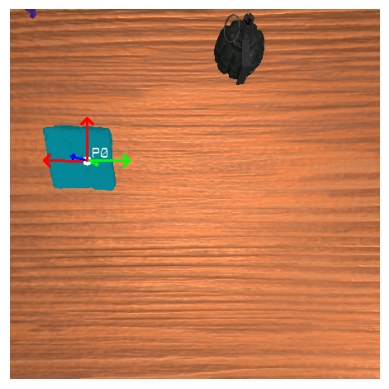

 80%|████████████████████████████████████████████████████████████████████                 | 12/15 [04:18<01:03, 21.20s/it]

text description
move realistic dark mushroom onto dentures
list_a
[-0.0692, 0.0916, 0]
tensor([[-0.0692,  0.0916,  0.0636]])
list_a before given to camera
[-0.0692, 0.0916, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.0692,  0.0916,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.0692,  0.0916,  0.0636]])
tensor([[-0.0692,  0.0916,  0.0636]])
check the difference
tensor([[-0.0678,  0.0909,  0.0600]])
tensor([[-0.0708,  0.0913,  0.1600]])
the pose of obj_start
tensor([-0.0777,  0.1017,  0.0000,  0.7690,  0.0000,  0.0000,  0.6392])
the pose of obj_end
tensor([-0.2666,  0.0257,  0.1000,  0.7690,  0.0000,  0.0000,  0.6392])
camera pose
Pose(raw_pose=tensor([[-0.0692,  0.0916,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


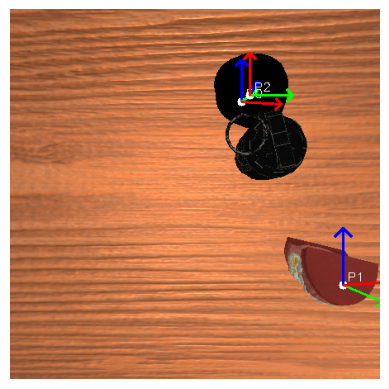

 87%|█████████████████████████████████████████████████████████████████████████▋           | 13/15 [04:44<00:45, 22.61s/it]

text description
move toy figure onto jar
list_a
[-0.0188, 0.0209, 0]
tensor([[-0.0188,  0.0209,  0.1209]])
list_a before given to camera
[-0.0188, 0.0209, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.0188,  0.0209,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.0188,  0.0209,  0.1209]])
tensor([[-0.0188,  0.0209,  0.1209]])
check the difference
tensor([[-0.0185,  0.0206,  0.1200]])
tensor([[-0.0207,  0.0192,  0.2200]])
the pose of obj_start
tensor([-0.0218,  0.0177,  0.0000,  0.5697, -0.0000, -0.0000, -0.8219])
the pose of obj_end
tensor([-0.3074,  0.1070,  0.1000,  0.5697, -0.0000, -0.0000, -0.8219])
camera pose
Pose(raw_pose=tensor([[-0.0188,  0.0209,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


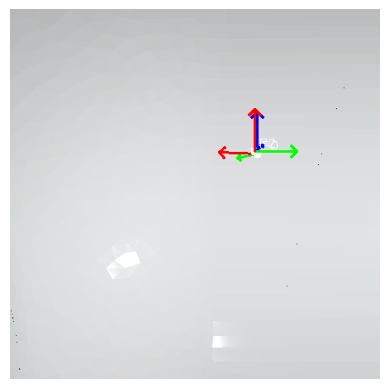

 93%|███████████████████████████████████████████████████████████████████████████████▎     | 14/15 [05:02<00:21, 21.24s/it]

text description
move seated oni figure onto orchid
list_a
[-0.3496, 0.1192, 0]
tensor([[-0.3496,  0.1192,  0.0724]])
list_a before given to camera
[-0.3496, 0.1192, 0]
render camera loc after rendering
Pose(raw_pose=tensor([[-0.3496,  0.1192,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))
intrinsic
tensor([[[410.0292,   0.0000, 224.0000],
         [  0.0000, 410.0292, 224.0000],
         [  0.0000,   0.0000,   1.0000]]])
first curve
tensor([[-0.3496,  0.1192,  0.0724]])
tensor([[-0.3496,  0.1192,  0.0724]])
check the difference
tensor([[-0.1991,  0.1201,  0.0700]])
tensor([[-0.2022,  0.1203,  0.1700]])
the pose of obj_start
tensor([-0.3529,  0.1105,  0.0000,  0.5220,  0.0000,  0.0000,  0.8529])
the pose of obj_end
tensor([-0.2168, -0.1026,  0.1500,  0.5220,  0.0000,  0.0000,  0.8529])
camera pose
Pose(raw_pose=tensor([[-0.3496,  0.1192,  0.4000,  0.7071,  0.0000,  0.7071,  0.0000]]))


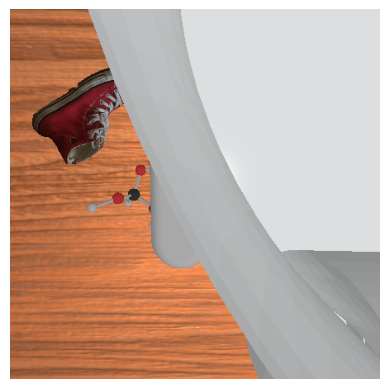

100%|█████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:24<00:00, 21.64s/it]


In [8]:
%load_ext autoreload
%autoreload 2
# For batch data collection without visualization
os.environ["TOKENIZERS_PARALLELISM"] = "false"
args = Args(
    robot_uids="panda_wristcam",
    record_dir="/work/dlclarge2/zhangj-zhangj-CFM/data/p6",
    N_samples=15,                # Number of samples to generate
    camera_views="top",
    object_dataset="objaverse",
    shader="default",
    obs_mode="rgb+segmentation+depth",
    render_mode="rgb_array",              # Disable visualization for speed
    num_envs=1,
    run_mode = "script",
    quiet = True
)

inital_seed = 2919129933 #2919129908
random.seed(inital_seed)
seeds = random.sample(range(0, 2**32), 15)
#args.seed = seeds
env_iter = iterate_env(args, vis=False)
for _ in tqdm(range(args.N_samples)):
            try:
                _ = next(env_iter)
            except StopIteration:
                break


In [ ]:
#[[175045574], [3113457551], [2542170577], [3893435155], [4207407346], [4264475535], [37484697], [3489624216], [3939266399], [3477784267], [2998306144], [1524371290], [1411403658], [3730714662], [3253628556]]
#[2603274749, 753606222, 24081061, 2040171868, 1774913893, 2908100739, 172158870, 
            #461653925, 2280014332, 3431745312, 433261562, 2068926005, 1277534805, 2311723683, 4033777556]

### Evaluate on the simulation evn

In [20]:
from pathlib import Path
#v17 = "cvla-clevr-camRF-sceneR-9__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_sortAll_augs_max20k_2025-04-27_18-00-52" # 6 - 20
#model_path = Path("/work/dlclarge2/bratulic-cvla/models/") / v17 / "checkpoint-19000"
model_path = Path("/data/lmbraid19/argusm/models/_text_lr3e-05xyzrotvec-cam-512xy256d_2025-04-23_12-03-48")/"checkpoint-4687"
#model_path = Path("/work/dlclarge2/bratulic-cvla/models")  / "_text_lr3e-05_enc512_128d_depth_2025-04-29_10-38-15" / "checkpoint-4687"
model = cVLA_wrapped(model_path=model_path)

NameError: name 'cVLA_wrapped' is not defined

In [ ]:
%load_ext autoreload
%autoreload 2
# For batch data collection without visualization
os.environ["TOKENIZERS_PARALLELISM"] = "false"

args = Args(
    robot_uids="panda_wristcam",
    record_dir="/work/dlclarge2/zhangj-zhangj-CFM/data",
    N_samples=20,                # Number of samples to generate
    object_dataset="objaverse",
    shader="default",
    obs_mode="rgb+segmentation",
    render_mode="rgb_array",              # Disable visualization for speed
    num_envs=1,
    run_mode = "script",
    quiet = True,
    action_encoder= model.enc_model.NAME
)

inital_seed = 2919129908
random.seed(inital_seed)
seeds = random.sample(range(0, 2**32), args.N_samples)
#args.seed = seeds

env_iter = iterate_env(args, vis=False, model=model)
for _ in tqdm(range(args.N_samples)):
            try:
                _ = next(env_iter)
            except StopIteration:
                break

### Find the largest h5 file

In [ ]:
import os

video_dir = "/work/dlclarge2/zhangj-zhangj-CFM/data/p_ran"

# Get list of .h5 files with their sizes
h5_files = [
    (f, os.path.getsize(os.path.join(video_dir, f)))
    for f in os.listdir(video_dir)
    if f.endswith('.h5')
]
print(h5_files)

# Select the file with the maximum size
if h5_files:
    largest_file = max(h5_files, key=lambda x: x[1])[0]
    print(f"Largest .h5 file: {largest_file}")
else:
    print("No .h5 files found.")
#Largest .h5 file: 20250522_155344.h5//20250522_164107.h5

### Generate the videos based on certain .h5 file

In [ ]:
from pathlib import Path

import cv2
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from cvla.data_loader_h5 import H5Dataset
video_dir = "/work/dlclarge2/zhangj-zhangj-CFM/data"
dataset_location = Path(video_dir) / "p_ran"/"20250708_081652.h5" # specify the h5 file
#"20250523_182213.h5"  "20250523_181858.h5"
#"20250523_175807.h5" #20250523_175522.h5" #20250523_174047.h5" 
#20250523_172840.h5"
dataset = H5Dataset(dataset_location)
video_dir = Path(video_dir)/ "video"
output_path = video_dir / "run_0.mp4"

for key in tqdm(sorted(dataset.h5_file.keys())):
    key2 = int(key[5]) + 13
    key2 = str("traj_") + str(key2)
    
    frames = dataset.h5_file[f"{key}/obs/sensor_data/render_camera/rgb"]

    # Define video parameters
    height, width = frames.shape[1:3]
    fps = 30  # or whatever frame rate you want
    output_path = video_dir / f'video_523_20_top_{key2}.mp4'

    # Define the video writer using MP4 codec
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1'
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write each frame
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # OpenCV expects BGR
        out.write(frame_bgr)

    out.release()
    print(f"Video saved to {output_path}")

In [ ]:
print(list(Path(args.record_dir).rglob("*.mp4")))

### save the images of top view

In [ ]:
import matplotlib.pyplot as plt
import torch

save_dir = "/work/dlclarge2/zhangj-zhangj-CFM/data/virtual_cam0"
images = virtual_cam_view

for i, image_tensor in enumerate(images):

    image_np = image_tensor.cpu().numpy()

    if image_np.shape[0] == 3:  
        image_np = image_np.transpose(1, 2, 0)
  
    save_path = os.path.join(save_dir, f"virtual_cam_{i}.png")  
    plt.imsave(save_path, image_np)  
    print(f"Saved: {save_path}") 


In [ ]:
print(len(virtual_cam_view))

### In time visualization

In [ ]:
from dataclasses import asdict
import json

# 1. Create an Args object with your desired parameters
args = Args(
    env_id="CvlaMove-v1",
    record_dir="/work/dlclarge2/zhangj-zhangj-CFM/data",  # Required for saving
    N_samples=50,                    # Number of samples to generate
    object_dataset="objaverse",          # or "ycb" or "objaverse"
    shader="default",                # or "rt" for ray tracing
    obs_mode="rgb+depth+segmentation",
    control_mode="pd_joint_pos",
    # Add other parameters as needed
)

# 2. For visualization (optional)
args.render_mode = "human"  # Enable visualization
args.num_envs = 1           # For visualization, keep at 1

# 3. Run the environment iteration
env_iter = iterate_env(args, vis=True)

# 4. To run a specific number of episodes:
for _ in range(5):  # Run 5 episodes
    try:
        image_before, json_dict, seed = next(env_iter)
        # You can process the outputs here
        print(f"Completed episode with seed {seed}")
    except StopIteration:
        break